In [ ]:
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)#

Mounted at /content/drive


In [ ]:
#!pip install quimb -U
#!pip install autoray
#!pip install --upgrade tbb
#!pip install --upgrade numba
#!pip install --upgrade dask
#!pip install pydash

In [ ]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools


In [ ]:
import sys, os
sys.path.insert(0, '../')
# My functions
from TNutils import *


In [ ]:
import TNutils
import importlib
importlib.reload(TNutils)
from TNutils import *

In [ ]:
# DATASET:
mnist = True      # Set False to use bars and stripes
restricted = False # use 14x14 instead of 28x28 if mnist is True
train_size = 500 # Size of the training set

# MPS:
initial_bdim = 16 # Initial bond dimension of MPS

# TRAINING:
period_epochs = 1  # Number of epochs per period
periods = 8        # Number of periods (at the end of eachperiod mps is saved and data in shown)
batch_size = 100   # batch_size
max_bond = 300      # maximum bond dimension during splits

# LR:
lr0 = 0.05         # Initial Learning Rate
momentum = 0.5     # Momentum term
s_factor = 0.01    # How strongly lr decreases during he epochs

In [ ]:
if mnist:
    train_set, test_set = get_data()
    shape = (28,28)
    if restricted:
        train_set = meanpool2d(train_set, shape)
        test_set  = meanpool2d(test_set, shape)
        shape     = (14,14)
else:
    train_set = np.array(bars_n_stripes(train_size))
    train_set = np.array([img.flatten() for img in train_set])
    test_set  = []
    shape= (4,4)

In [ ]:
imgs = train_set[:train_size]

# Convert accordingly
_imgs = np.array([tens_picture(img) for img in imgs])

# Initialize MPS
mps = initialize_mps(imgs.shape[1],bdim=initial_bdim)

In [ ]:
sav_lr = mps_lr(mps, lr0, momentum, s_factor)
update_wrap = lambda site, div: sav_lr.J(site, div)

In [ ]:
inds_dict = {'left': imgs.shape[1]*[None], 'right': imgs.shape[1]*[None], 'mps': imgs.shape[1]*[None], 'imgs': imgs.shape[1]*[None]}

In [ ]:
torch_mps   = torchized_mps(mps,inds_dict)
torch_imgs  = torchized_imgs(_imgs,inds_dict)
torch_cache = torchized_cache(torch_mps,torch_imgs,inds_dict)

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 142.35987961595274 | Baseline: 6.214608098422191


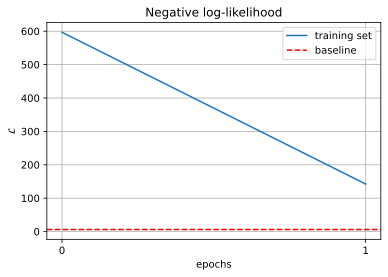

/content/TNutils.py:1846: RuntimeWarning: invalid value encountered in true_divide
  cond_p_arr = into_data(p_arr)/into_data(tneinsum3(half_contr,half_contr))


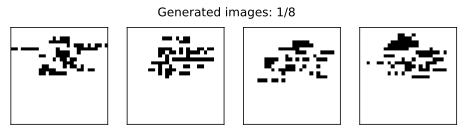

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 90.97443529032024 | Baseline: 6.214608098422191


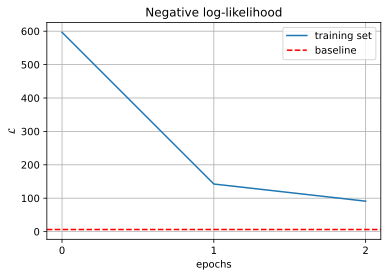

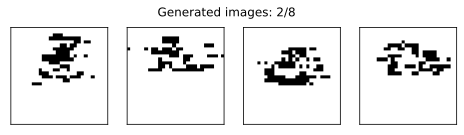

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 66.67713293170928 | Baseline: 6.214608098422191


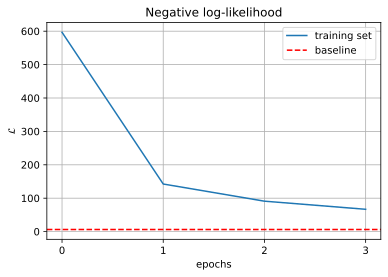

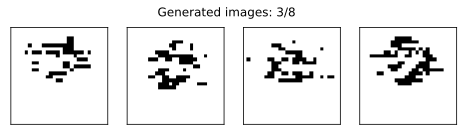

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 56.41897857666016 | Baseline: 6.214608098422191


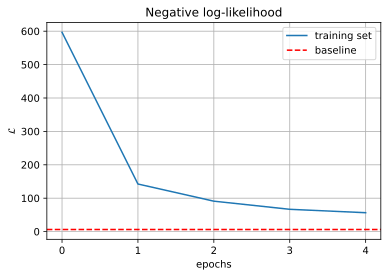

/content/TNutils.py:1846: RuntimeWarning: divide by zero encountered in true_divide
  cond_p_arr = into_data(p_arr)/into_data(tneinsum3(half_contr,half_contr))


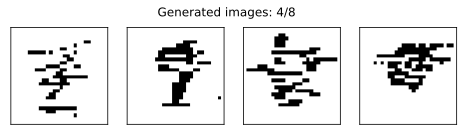

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 50.68840216064453 | Baseline: 6.214608098422191


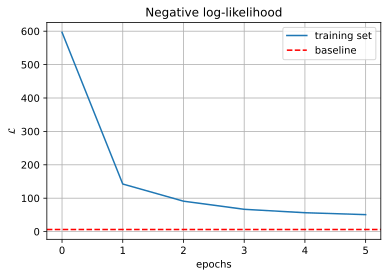

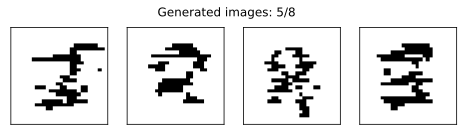

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

NLL: 46.870252929687496 | Baseline: 6.214608098422191


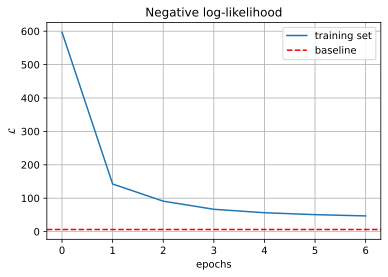

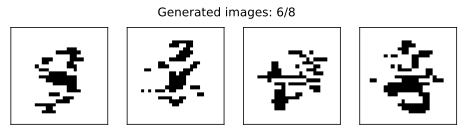

epoch 1/1


  0%|          | 0/1566 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/quimb/tensor/tensor_core.py:1556: RuntimeWarning: divide by zero encountered in true_divide
  return Tensor(data=op(self.data, other),
/usr/local/lib/python3.7/dist-packages/quimb/tensor/tensor_core.py:1556: RuntimeWarning: invalid value encountered in true_divide
  return Tensor(data=op(self.data, other),
/usr/local/lib/python3.7/dist-packages/quimb/tensor/decomp.py:127: UserWarning: TN SVD failed, trying again with alternate driver.
  warnings.warn("TN SVD failed, trying again with alternate driver.")


ValueError: ignored

In [ ]:
costs, samples = training_and_probing_torched(
    period_epochs,
    periods,
    mps,
    inds_dict,
    torch_mps,
    shape,
    imgs,
    _imgs,
    torch_imgs,
    torch_cache,
    batch_size,
    lr0,#sav_lr,
    #update_wrap = update_wrap,
    lr_update = lambda x: x*0.95,#lr_update = lr_update,
    val_imgs = [],
    period_samples = 4,
    corrupted_set = None,
    plot = True,
    path = 'dummy_dir/',
    max_bond = max_bond
    )